In [3]:
import pandas as pd
from sqlalchemy import create_engine
import requests
from config import ninja_api
import json
import psycopg2
import matplotlib.pyplot as plt

In [4]:
api_url = 'https://api.api-ninjas.com/v1/country?name='

In [5]:
owid_df = pd.read_csv('./Resources/owid-covid-data.csv')
owid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [6]:
red_owid_df = owid_df.copy()
red_owid_df = red_owid_df[['iso_code','continent', 'location', 'date', 'population', 
                           'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters']] 
                           #,'new_vaccinations', 'new_vaccinations_smoothed']]
red_owid_df

,iso_code,continent,location,date,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters
0,AFG,Asia,Afghanistan,2020-02-24,39835428.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,39835428.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,39835428.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,39835428.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,39835428.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
163782,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,4336161.0,3367921.0,106474.0
163783,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,4338919.0,3371563.0,110403.0
163784,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,4340412.0,3372616.0,110866.0
163785,ZWE,Africa,Zimbabwe,2022-02-21,15092171.0,7829096.0,4342121.0,3374371.0,112604.0


In [7]:
clean_df = red_owid_df.copy()
clean_df.dropna(inplace=True)
clean_df.reset_index(drop = True, inplace = True)
clean_df

,iso_code,continent,location,date,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,1025180.0,898625.0,2799.0
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,1031588.0,904858.0,8230.0
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,1032457.0,905876.0,8815.0
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,1037546.0,910845.0,14968.0
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,1040015.0,913524.0,18434.0
...,...,...,...,...,...,...,...,...,...
12019,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,4336161.0,3367921.0,106474.0
12020,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,4338919.0,3371563.0,110403.0
12021,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,4340412.0,3372616.0,110866.0
12022,ZWE,Africa,Zimbabwe,2022-02-21,15092171.0,7829096.0,4342121.0,3374371.0,112604.0


In [8]:
clean_country_df = clean_df.copy()
for n, row in clean_country_df.iterrows():
    row['location'] = row['location'].split('(', 1)[0]
clean_country_df

,iso_code,continent,location,date,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,1025180.0,898625.0,2799.0
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,1031588.0,904858.0,8230.0
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,1032457.0,905876.0,8815.0
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,1037546.0,910845.0,14968.0
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,1040015.0,913524.0,18434.0
...,...,...,...,...,...,...,...,...,...
12019,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,4336161.0,3367921.0,106474.0
12020,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,4338919.0,3371563.0,110403.0
12021,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,4340412.0,3372616.0,110866.0
12022,ZWE,Africa,Zimbabwe,2022-02-21,15092171.0,7829096.0,4342121.0,3374371.0,112604.0


In [9]:
perc_df = clean_country_df.copy()
perc_df['perc_vaccinated'] = perc_df['people_vaccinated']/perc_df['population']
perc_df['perc_fully_vaccinated'] = perc_df['people_fully_vaccinated']/perc_df['population']
perc_df

,iso_code,continent,location,date,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,perc_vaccinated,perc_fully_vaccinated
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,1025180.0,898625.0,2799.0,0.356841,0.312790
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,1031588.0,904858.0,8230.0,0.359071,0.314960
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,1032457.0,905876.0,8815.0,0.359374,0.315314
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,1037546.0,910845.0,14968.0,0.361145,0.317043
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,1040015.0,913524.0,18434.0,0.362004,0.317976
...,...,...,...,...,...,...,...,...,...,...,...
12019,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,4336161.0,3367921.0,106474.0,0.287312,0.223157
12020,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,4338919.0,3371563.0,110403.0,0.287495,0.223398
12021,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,4340412.0,3372616.0,110866.0,0.287594,0.223468
12022,ZWE,Africa,Zimbabwe,2022-02-21,15092171.0,7829096.0,4342121.0,3374371.0,112604.0,0.287707,0.223584


In [10]:
final_df = perc_df.copy()
final_df.drop(['people_vaccinated', 'people_fully_vaccinated'], axis=1, inplace=True)
final_df.index.names = ['id']
final_df

,iso_code,continent,location,date,population,total_vaccinations,total_boosters,perc_vaccinated,perc_fully_vaccinated
id,,,,,,,,,
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,2799.0,0.356841,0.312790
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,8230.0,0.359071,0.314960
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,8815.0,0.359374,0.315314
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,14968.0,0.361145,0.317043
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,18434.0,0.362004,0.317976
...,...,...,...,...,...,...,...,...,...
12019,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,106474.0,0.287312,0.223157
12020,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,110403.0,0.287495,0.223398
12021,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,110866.0,0.287594,0.223468


In [11]:
countries = final_df['iso_code'].unique()
countries

array(['ALB', 'DZA', 'AND', 'AIA', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE',
       'BHS', 'BHR', 'BGD', 'BLR', 'BEL', 'BLZ', 'BMU', 'BTN', 'BOL',
       'BRA', 'KHM', 'CAN', 'CHL', 'CHN', 'COL', 'CRI', 'CUB', 'CUW',
       'CYP', 'CZE', 'DNK', 'DOM', 'ECU', 'SLV', 'EST', 'FRO', 'FIN',
       'FRA', 'DEU', 'GIB', 'GRC', 'GRD', 'GTM', 'GGY', 'GUY', 'HND',
       'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRL', 'IMN', 'ISR',
       'ITA', 'JAM', 'JPN', 'JEY', 'KAZ', 'KEN', 'OWID_KOS', 'KWT', 'LVA',
       'LBN', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MYS', 'MDV', 'MLT',
       'MCO', 'MNG', 'MNE', 'NPL', 'NLD', 'NZL', 'MKD', 'NOR', 'OMN',
       'PAK', 'PAN', 'PRY', 'PER', 'POL', 'PRT', 'RUS', 'KNA', 'VCT',
       'SMR', 'SAU', 'SRB', 'SGP', 'SVK', 'SVN', 'ZAF', 'KOR', 'ESP',
       'LKA', 'SUR', 'SWE', 'CHE', 'TWN', 'THA', 'TTO', 'TUN', 'TUR',
       'UKR', 'ARE', 'GBR', 'USA', 'URY', 'VEN', 'VNM', 'ZWE'],
      dtype=object)

In [35]:
countries_df = pd.DataFrame(columns = ['iso_code', 'GDP', 'Population Density', 'Urbanization', 'Unemployment'])
purged_countries = []
for nat in countries:
    response = requests.get(api_url+nat, headers={'X-Api-Key':ninja_api}).json()
    try:
        new_country_df = pd.DataFrame({'iso_code':[nat], 'GDP': [response[0]['gdp']], 
                                       'Population Density':[response[0]['pop_density']], 
                                       'Urbanization': [response[0]['urban_population']], 
                                       'Unemployment': [response[0]['unemployment']]})
        countries_df = pd.concat([countries_df, new_country_df], ignore_index = True, axis = 0)
        purged_countries.append(nat)
    except (IndexError, KeyError):
        print(f'{nat} is not a valid country for the API')
countries_df.set_index('iso_code', inplace=True)
countries_df

AND is not a valid country for the API
AIA is not a valid country for the API
FRO is not a valid country for the API
GIB is not a valid country for the API
GRD is not a valid country for the API
GGY is not a valid country for the API
IMN is not a valid country for the API
JEY is not a valid country for the API
OWID_KOS is not a valid country for the API
MCO is not a valid country for the API
KNA is not a valid country for the API
TWN is not a valid country for the API


,GDP,Population Density,Urbanization,Unemployment
iso_code,,,,
ALB,15059.0,105.0,61.2,12.8
DZA,173757.0,18.4,73.2,11.5
ARG,518475.0,16.5,92.0,10.4
ARM,12433.0,104.1,63.2,16.6
AUS,1453871.0,3.3,86.1,5.3
...,...,...,...,...
USA,20580223.0,36.2,82.5,3.9
URY,59597.0,19.8,95.4,8.8
VEN,208338.0,32.2,88.2,9.4


In [37]:
purged_final_df = final_df.loc[final_df['iso_code'].isin(purged_countries)]
purged_final_df

,iso_code,continent,location,date,population,total_vaccinations,total_boosters,perc_vaccinated,perc_fully_vaccinated
id,,,,,,,,,
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,2799.0,0.356841,0.312790
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,8230.0,0.359071,0.314960
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,8815.0,0.359374,0.315314
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,14968.0,0.361145,0.317043
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,18434.0,0.362004,0.317976
...,...,...,...,...,...,...,...,...,...
12019,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,106474.0,0.287312,0.223157
12020,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,110403.0,0.287495,0.223398
12021,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,110866.0,0.287594,0.223468


In [38]:
conn_string = 'postgres:postgres@localhost:5432/vaccinations_db'
engine = create_engine(f'postgresql://{conn_string}')

In [39]:
engine.table_names()

C:\Users\wawil\AppData\Local\Temp/ipykernel_42360/4162273999.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['vaccinations', 'stats']

In [40]:
purged_final_df.to_sql(name='vaccinations', con = engine, if_exists='replace', index = True)

In [41]:
countries_df.to_sql(name='stats', con = engine, if_exists = 'replace', index = True)

# Analysis

In [42]:
merged_df = purged_final_df.merge(countries_df, how= 'inner', on = 'iso_code')
merged_df

,iso_code,continent,location,date,population,total_vaccinations,total_boosters,perc_vaccinated,perc_fully_vaccinated,GDP,Population Density,Urbanization,Unemployment
0,ALB,Europe,Albania,2021-11-03,2872934.0,1926604.0,2799.0,0.356841,0.312790,15059.0,105.0,61.2,12.8
1,ALB,Europe,Albania,2021-11-06,2872934.0,1944676.0,8230.0,0.359071,0.314960,15059.0,105.0,61.2,12.8
2,ALB,Europe,Albania,2021-11-07,2872934.0,1947148.0,8815.0,0.359374,0.315314,15059.0,105.0,61.2,12.8
3,ALB,Europe,Albania,2021-11-09,2872934.0,1963359.0,14968.0,0.361145,0.317043,15059.0,105.0,61.2,12.8
4,ALB,Europe,Albania,2021-11-10,2872934.0,1971973.0,18434.0,0.362004,0.317976,15059.0,105.0,61.2,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11714,ZWE,Africa,Zimbabwe,2022-02-18,15092171.0,7810556.0,106474.0,0.287312,0.223157,24312.0,38.4,32.2,5.0
11715,ZWE,Africa,Zimbabwe,2022-02-19,15092171.0,7820885.0,110403.0,0.287495,0.223398,24312.0,38.4,32.2,5.0
11716,ZWE,Africa,Zimbabwe,2022-02-20,15092171.0,7823894.0,110866.0,0.287594,0.223468,24312.0,38.4,32.2,5.0
11717,ZWE,Africa,Zimbabwe,2022-02-21,15092171.0,7829096.0,112604.0,0.287707,0.223584,24312.0,38.4,32.2,5.0


In [77]:
latest_df = merged_df.loc[merged_df['date'] == max(merged_df['date'])]
latest_df

,iso_code,continent,location,date,population,total_vaccinations,total_boosters,perc_vaccinated,perc_fully_vaccinated,GDP,Population Density,Urbanization,Unemployment
128,ARG,South America,Argentina,2022-02-22,4.560582e+07,9.255138e+07,16198652.0,0.882092,0.785840,518475.0,16.5,92.0,10.4
273,AUS,Oceania,Australia,2022-02-22,2.578822e+07,5.336540e+07,10940087.0,0.852803,0.792340,1453871.0,3.3,86.1,5.3
498,BGD,Asia,Bangladesh,2022-02-22,1.663035e+08,1.846058e+08,3227332.0,0.621508,0.469139,269628.0,1265.2,37.4,4.2
973,BRA,South America,Brazil,2022-02-22,2.139934e+08,3.872262e+08,61867668.0,0.825378,0.718602,1868613.0,25.4,86.8,12.0
1539,CAN,North America,Canada,2022-02-22,3.806791e+07,8.059450e+07,17250604.0,0.854796,0.809175,1712562.0,4.2,81.5,5.4
1912,CUW,North America,Curacao,2022-02-22,1.647960e+05,2.439310e+05,39183.0,0.647188,0.595245,3128.0,369.6,89.1,13.0
2206,CZE,Europe,Czechia,2022-02-22,1.072455e+07,1.735119e+07,3982848.0,0.647168,0.637549,245226.0,138.6,73.9,1.9
3395,FIN,Europe,Finland,2022-02-22,5.548361e+06,1.142572e+07,2738580.0,0.805403,0.760310,276878.0,18.2,85.4,6.7
4347,GRC,Europe,Greece,2022-02-22,1.037075e+07,1.982792e+07,5231904.0,0.756581,0.720020,218139.0,80.9,79.4,15.5
4789,ISL,Europe,Iceland,2022-02-22,3.687920e+05,8.014200e+05,247947.0,0.838885,0.783694,25882.0,3.4,93.9,3.2


In [78]:
latest_date = {}
for country in purged_countries:
    temp_df = merged_df.loc[merged_df['iso_code'] == country]
    latest_date[country] = max(temp_df['date'])
print(latest_date)

{'ALB': '2022-02-20', 'DZA': '2021-11-29', 'ARG': '2022-02-22', 'ARM': '2022-02-13', 'AUS': '2022-02-22', 'AUT': '2022-02-11', 'AZE': '2022-02-16', 'BHS': '2022-02-16', 'BHR': '2022-02-09', 'BGD': '2022-02-22', 'BLR': '2022-01-16', 'BEL': '2022-02-21', 'BLZ': '2022-02-18', 'BMU': '2022-02-18', 'BTN': '2022-01-30', 'BOL': '2022-02-21', 'BRA': '2022-02-22', 'KHM': '2022-02-20', 'CAN': '2022-02-22', 'CHL': '2022-02-16', 'CHN': '2022-02-07', 'COL': '2022-02-20', 'CRI': '2022-02-21', 'CUB': '2022-02-20', 'CUW': '2022-02-22', 'CYP': '2022-02-21', 'CZE': '2022-02-22', 'DNK': '2022-02-21', 'DOM': '2022-02-21', 'ECU': '2022-02-20', 'SLV': '2022-02-15', 'EST': '2022-02-21', 'FIN': '2022-02-22', 'FRA': '2022-02-21', 'DEU': '2022-02-21', 'GRC': '2022-02-22', 'GTM': '2022-02-18', 'GUY': '2022-02-19', 'HND': '2022-01-21', 'HKG': '2022-02-20', 'HUN': '2022-02-14', 'ISL': '2022-02-22', 'IND': '2022-02-22', 'IDN': '2022-02-22', 'IRN': '2022-02-22', 'IRL': '2022-02-21', 'ISR': '2022-02-22', 'ITA': '2022

In [87]:
latest_df = pd.DataFrame(columns = merged_df.keys())

for country in purged_countries:
    temp_df = merged_df.loc[((merged_df['iso_code'] == country) & (merged_df['date'] == latest_date[country]))]
    latest_df = pd.concat([latest_df, temp_df], ignore_index = True, axis = 0)
latest_df

,iso_code,continent,location,date,population,total_vaccinations,total_boosters,perc_vaccinated,perc_fully_vaccinated,GDP,Population Density,Urbanization,Unemployment
0,ALB,Europe,Albania,2022-02-20,2872934.0,2683715.0,229289.0,0.440638,0.413690,15059.0,105.0,61.2,12.8
1,DZA,Africa,Algeria,2021-11-29,44616626.0,12145830.0,25381.0,0.151066,0.120591,173757.0,18.4,73.2,11.5
2,ARG,South America,Argentina,2022-02-22,45605823.0,92551383.0,16198652.0,0.882092,0.785840,518475.0,16.5,92.0,10.4
3,ARM,Asia,Armenia,2022-02-13,2968128.0,1959789.0,15539.0,0.359586,0.295456,12433.0,104.1,63.2,16.6
4,AUS,Oceania,Australia,2022-02-22,25788217.0,53365398.0,10940087.0,0.852803,0.792340,1453871.0,3.3,86.1,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,USA,North America,United States,2022-02-22,332915074.0,550924900.0,93094542.0,0.760121,0.643435,20580223.0,36.2,82.5,3.9
100,URY,South America,Uruguay,2022-02-22,3485152.0,7582440.0,1910870.0,0.849822,0.777531,59597.0,19.8,95.4,8.8
101,VEN,South America,Venezuela,2022-02-04,28704947.0,36962256.0,410887.0,0.757282,0.492554,208338.0,32.2,88.2,9.4
102,VNM,Asia,Vietnam,2022-02-21,98168829.0,191993381.0,35599393.0,0.809755,0.783358,244901.0,313.9,36.6,2.0


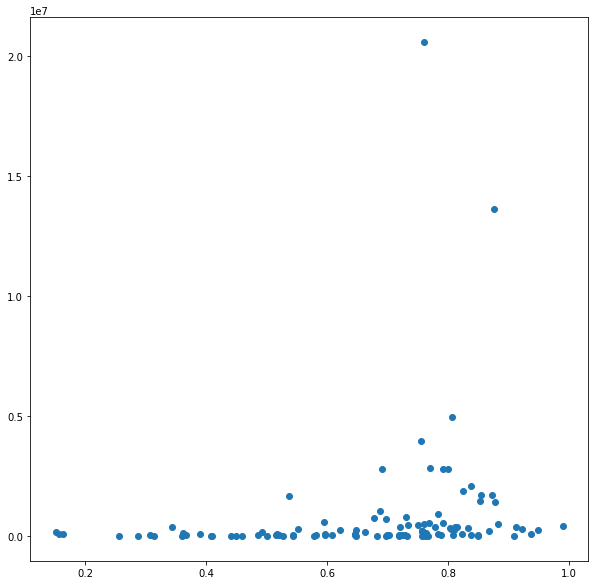

In [93]:
plt.figure(figsize=(10,10))

plt.scatter(latest_df['perc_vaccinated'], latest_df['GDP'], )
plt.show()

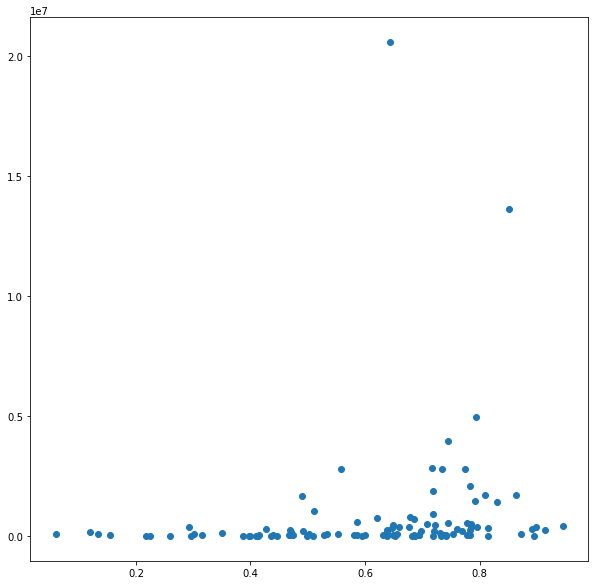

In [94]:
plt.figure(figsize=(10,10))

plt.scatter(latest_df['perc_fully_vaccinated'], latest_df['GDP'])
plt.show()